# Apache Beam  Pipeline
Showing how stitching can be done on apache beam engine.

## Input Stream
Input stream consists of metadata elements informing that Nth element from Mth strip is ready to fetch using given fetcher and arguments.

In [1]:
stripe_count = 7
version_count = 5

demo_image_source_args = {
    "stripe_count": stripe_count,
    "version_count": version_count,
    "channel_count": 1,
    "vertical_shifts": (19, 38, 0),
    "overlap": 0.4,
}

Demo data

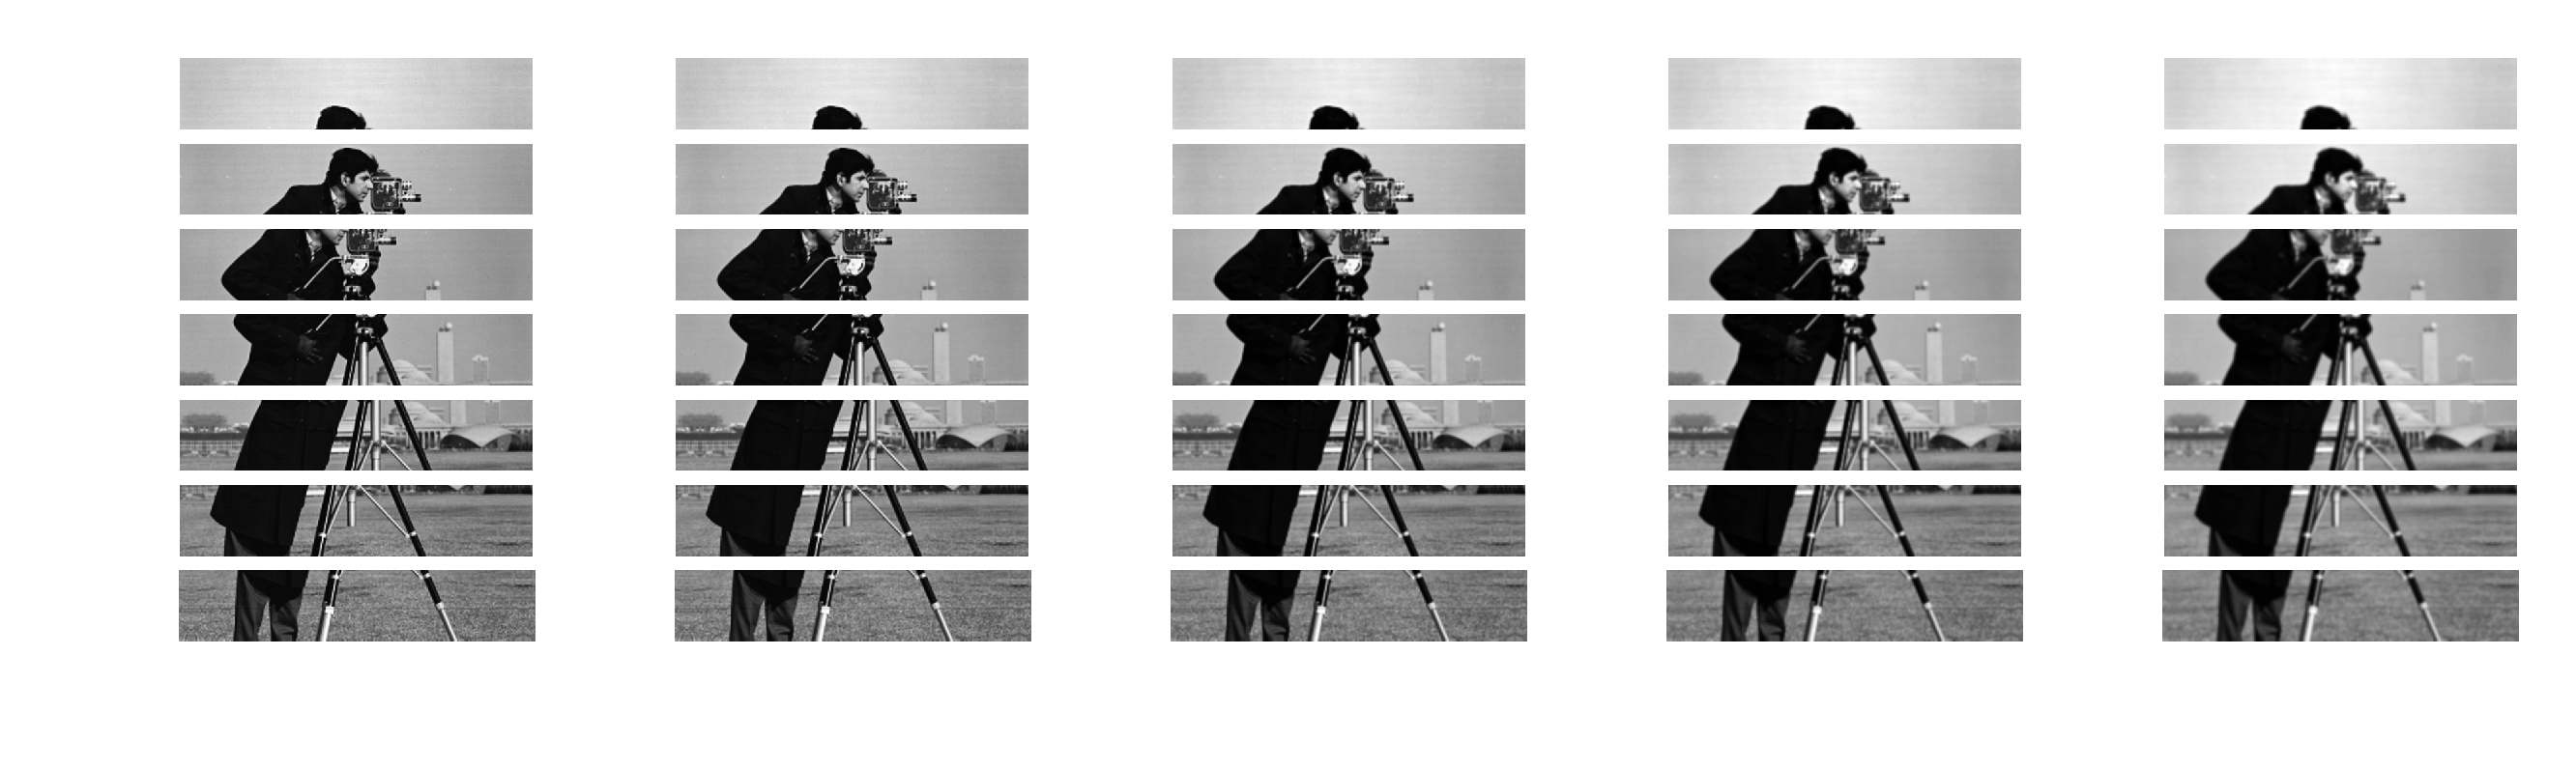

In [2]:
from alpenglow.image_sources.demo import DemoImageSource
image_source = DemoImageSource(**demo_image_source_args)

from skimage import data

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 2), dpi=400)

for version_id in range(version_count):
    for stripe_id in range(stripe_count):
        ax = fig.add_subplot(stripe_count, version_count, 1 + version_id + version_count * stripe_id)
        ax.imshow(image_source.get_image(stripe_id, version_id), cmap='gray')
        ax.set_axis_off()
plt.show()

In [8]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions


p = beam.Pipeline(options=PipelineOptions())

In [9]:
input_stream = p | "read demo stream" >> beam.Create([(version_id, stripe_id) for stripe_id in range(stripe_count) for version_id in range(version_count)])
input_stream | "write input stream" >> beam.io.WriteToText('/tmp/beam/input')

<PCollection[write input stream/Write/WriteImpl/FinalizeWrite.None] at 0x1107a7f90>

In [10]:
def select_N(x):  # filter accepting N indexes evently distributed in M
    return (((x[0] + 1) * x[2]) % x[1]) == 0 or int((x[0] + 1) * x[2] / x[1]) > int(x[0] * x[2] / x[1])

N = 5 # sample constant
M = 52
list(filter(select_N, [(i, M, N) for i in range(M)]))

[(10, 52, 5), (20, 52, 5), (31, 52, 5), (41, 52, 5), (51, 52, 5)]

In [11]:
sample_N = 2

sampled_input_stream = input_stream | "sample input stream" >> beam.FlatMap(lambda x: [x] if select_N((x[0], version_count, sample_N)) else [])
sampled_input_stream | "write sampled stream" >> beam.io.WriteToText('/tmp/beam/sampled_input')

<PCollection[write sampled stream/Write/WriteImpl/FinalizeWrite.None] at 0x1107b5050>

In [12]:
def joinStripes(stripe, savedStripe):
    if savedStripe is None:
       savedStripe = 0
    return sum(stripe, savedStripe)

joined_stream = sampled_input_stream.updateStateByKey(joinStripes)
joined_stream | "write joned stream" >> beam.io.WriteToText('/tmp/beam/joined_stream')

AttributeError: 'PCollection' object has no attribute 'updateStateByKey'

In [7]:
p.run()